# This notebook implements Random Forest Regression for the data from a Social Force Model.
The data must be located in the data folder


In [1]:
import os
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import matplotlib.pyplot as plt
#import gp_emulator
os.chdir("/Users/MinhKieu/Documents/Research/Emulator_ABM")  #Mac
print("checked")

checked


In [2]:
# define RMSE
def rmse(dataset1, dataset2, ignore=None):

   # Make sure that the provided data sets are numpy ndarrays, if not
   # convert them and flatten te data sets for analysis
   if type(dataset1).__module__ != np.__name__:
      d1 = np.asarray(dataset1).flatten()
   else:
      d1 = dataset1.flatten()

   if type(dataset2).__module__ != np.__name__:
      d2 = np.asarray(dataset2).flatten()
   else:
      d2 = dataset2.flatten()

   # Make sure that the provided data sets are the same size
   if d1.size != d2.size:
      raise ValueError('Provided datasets must have the same size/shape')

   # Check if the provided data sets are identical, and if so, return 0
   # for the root-mean-squared error
   if np.array_equal(d1, d2):
      return 0

   # If specified, remove the values to ignore from the analysis and compute
   # the element-wise difference between the data sets
   if ignore is not None:
      index = np.intersect1d(np.where(d1 != ignore)[0], 
                                np.where(d2 != ignore)[0])
      error = d1[index].astype(np.float64) - d2[index].astype(np.float64)
   else:
      error = d1.astype(np.float64) - d2.astype(np.float64)

   # Compute the mean-squared error
   meanSquaredError = np.sum(error**2) / error.size

   # Return the root of the mean-square error
   return np.sqrt(meanSquaredError)

In [3]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Narrow corridor, Stable demand, Train on Demand = 2,4,6pedestrian/2s, then test on Demand = 2,3,4,5,6,7 pedestrian/2s

### Mid term prediction: We take the counts when time = 120s, then predict the final crowding at the end of the period

We train the Emulator with data where demand = 1,2,3 ped/s

And then we give a new data when demand = 1, 1.5, 2, 2.5, 3, 3.5 for testing




In [4]:
#load simulated training data:
data = np.genfromtxt('./data/agg-1-3-5.csv', delimiter=',')
#data = data[data[:,0]>100]
#x: Time, count_gate x 9 (10 columns)
#y: mean_speed,std_speed,mean_xforce,std_xforce  (4 columns)


In [5]:
def create_average(y_train):
    y_train_final = list()
    #creates array for average values
    for i,d in enumerate(y_train):
        if ((i+1) % 3) == 0:
            #print(i)
            avg_y_train = np.mean(y_train[i - 2:(i+1)])
            if np.isnan(avg_y_train):
                print(y_train[i - 3:i])
            #print(avg_y_train)
            y_train_final.append(avg_y_train)
    return y_train_final

In [6]:
## process data to make predictions: X= Xt, Y = [Speed,Social Force]
x_train = data[data[:,0]==60,]
x_train = x_train[:,(1,3,5,7,9,11,13,15,17)]

y_train=(data[data[:,0]>240,19])

y_train_final = create_average(y_train)

print(y_train_final)
#print(y_test[:5])

[0.12366666666666666, 0.16666666666666666, 0.17166666666666666, 0.050333333333333334, 0.11599999999999999, 0.05033333333333334, 0.12033333333333333, 0.044333333333333336, 0.16933333333333334]


In [7]:
print(x_train)
print(y_train)

[[48.000 47.000 49.000 46.000 48.000 43.000 39.000 26.000 24.000]
 [79.000 74.000 75.000 78.000 77.000 74.000 56.000 46.000 35.000]
 [76.000 81.000 78.000 79.000 73.000 79.000 70.000 45.000 30.000]
 [15.000 12.000 17.000 14.000 14.000 14.000 16.000 15.000 10.000]
 [48.000 45.000 44.000 53.000 40.000 52.000 40.000 27.000 21.000]
 [16.000 17.000 16.000 20.000 18.000 15.000 12.000 9.000 6.000]
 [45.000 46.000 48.000 37.000 38.000 41.000 42.000 28.000 25.000]
 [15.000 15.000 16.000 14.000 9.000 15.000 17.000 14.000 8.000]
 [80.000 79.000 76.000 78.000 75.000 80.000 81.000 51.000 21.000]]
[0.121 0.117 0.133 0.166 0.176 0.158 0.169 0.177 0.169 0.052 0.052 0.047
 0.112 0.116 0.120 0.058 0.048 0.045 0.112 0.121 0.128 0.050 0.050 0.033
 0.164 0.162 0.182]


In [8]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#sc.fit(X_train)
#X_train = sc.transform(x_train)
X_train = sc.fit_transform(x_train)

In [9]:
#now train a new RF model
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=500, random_state=1)
regressor.fit(X_train, y_train_final)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [10]:
# Main modelling block

pred_results = list()
y_test_list = list()
for i in range(1,7):
    #load testing data
    #print(i)
    filename = './data/val-'+ str(i) +'ped.csv'
    #print(filename)
    test_data = np.genfromtxt(filename, delimiter=',')
    #print(test_data)
    #test_data = test_data[test_data[:,0]>100]
    #x: flow in at each `check point', or `cell': x_i^t
    #y: mean_speed,std_speed,mean_xforce,std_xforce
    x_test = test_data[test_data[:,0]==60,]
    x_test = x_test[:,(1,3,5,7,9,11,13,15,17)]
    X_test = sc.transform(x_test)
    #print(x_test[0])
    #x_test_list.append(x_test[0])
    
    #print(x_test_list)
    y_test=np.mean(test_data[test_data[:,0]>240,19])
    print(y_test)
    y_test_list.append(y_test)
    
    y_pred= regressor.predict(X_test)
    pred_results.append(y_pred[0])
 
    #print(y_unc)
    #print(y_pred)
    #pred_results.append(y_pred)
#print(x_test_list)
print(y_test_list)
print(pred_results)


0.04699999999999999
0.09299999999999999
0.11699999999999999
0.1386666666666667
0.16733333333333333
0.18866666666666668
[0.04699999999999999, 0.09299999999999999, 0.11699999999999999, 0.1386666666666667, 0.16733333333333333, 0.18866666666666668]
[0.05104733333333359, 0.08059466666666688, 0.1185399999999996, 0.1512006666666665, 0.16593599999999972, 0.16808799999999963]


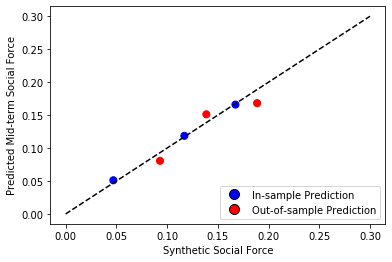

In [11]:

# Plot predicted MPG without error bars
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='None', label='In-sample Prediction',
                          markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='None', label='Out-of-sample Prediction',
                          markerfacecolor='r', markersize=10)]

y = ['b','r','b','r','b','r']

plt.scatter(y_test_list, pred_results, c=y, s=50)
plt.legend(handles=legend_elements, loc='lower right')
plt.plot([0, 0.3], [0, 0.3], 'k--')
plt.xlabel('Synthetic Social Force')
plt.ylabel('Predicted Mid-term Social Force')
#plt.savefig('NHPP_aggregated_same.pdf')
plt.savefig('Figures/Mid-term-prediction-RF.pdf')
plt.show()


In [12]:
#print('Mean Absolute Percentage Error:', mape(pred_results,y_test_list))
print('Mean Absolute Percentage Error:', mape(y_test_list,pred_results))
print('Root Mean Squared Error:', rmse(pred_results,y_test_list))

Mean Absolute Percentage Error: 7.341346249612765
Root Mean Squared Error: 0.011218883043366748


## Narrow corridor, Stable demand, Train on Demand = 2,4,6pedestrian/2s, then test on Demand = 2,3,4,5,6,7 pedestrian/2s

Short-term prediction: We try to predict the next minute

The demand keeps changing over time



In [13]:
minT = 45
maxT = 285
timeStep = 15

#load simulated training data: #switch better same and narrow experiment
data = np.genfromtxt('./data/agg-1-3-5.csv', delimiter=',')
data = data[data[:,0]>minT]
#x: Time, count_gate x 9 (10 columns)
#y: mean_speed,std_speed,mean_xforce,std_xforce  (4 columns)

In [14]:
## process data to make predictions: X= Xt, Y = [Speed,Social Force]
x_train = data[:-1,(0,1,3,5,7,9,11,13,15,17)]

y_train=data[1:,19]


In [15]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#sc.fit(X_train)
#X_train = sc.transform(x_train)
X_train = sc.fit_transform(x_train)

In [16]:
#now train a new RF model
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=500, random_state=1)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

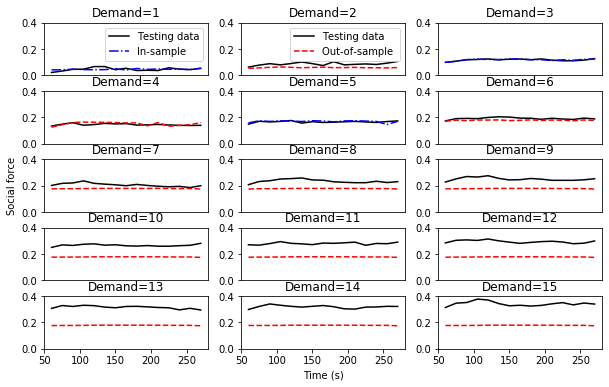

In [18]:

# Main modelling block
fig, axs = plt.subplots(5,3, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)

axs = axs.ravel()

#import forestci as fci
pred_results = list()
y_test_list = list()
X_train_list = []
X_test_list = []
for i in range(1,16):
    #load testing data
    #print(i)
    filename = './data/val-'+ str(i) +'ped.csv'
    #print(filename)
    test_data = np.genfromtxt(filename, delimiter=',')
    #print(test_data)
    test_data = test_data[test_data[:,0]>minT]
    #x: flow in at each `check point', or `cell': x_i^t
    #y: mean_speed,std_speed,mean_xforce,std_xforce
    x_test = test_data[:-1,(0,1,3,5,7,9,11,13,15,17)]
    X_test = sc.transform(x_test)
    y_test=test_data[1:,19]
    
    #make predictions using the trained model
    y_pred = regressor.predict(X_test)
    axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_test,'k-',label='Testing data')
    axs[i-1].set_title('Demand='+ str(i))
    
    if (i<13):
        axs[i-1].get_xaxis().set_visible(False)
    if (i==1):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'b-.',label='In-sample ')
        legend = axs[i-1].legend(loc='upper right')        
    if (i==2):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
        legend = axs[i-1].legend(loc='upper right')
    if (i==3):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'b-.',label='In-sample ')
    if (i==4):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
        #legend = axs[i-1].legend(loc='lower right')
    if (i==5):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'b-.',label='In-sample ')
    if (i==6):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
    if (i==7):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
        axs[i-1].set_ylabel('Social force')
    if (i>=8):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
        
    if (i==14):
        axs[i-1].set_xlabel('Time (s)')
                
    axs[i-1].set_ylim(0, 0.4)
    #Save to the overall storage
    pred_results.append(y_pred)
    y_test_list.append(y_test)

pred_results=np.hstack(pred_results)
y_test_list=np.hstack(y_test_list)

plt.savefig('Figures/Short-term-prediction-RF.pdf')
plt.show()    
#print(pred_results)
#print(y_test_list)

In [90]:
#print('Mean Absolute Percentage Error:', mape(pred_results,y_test_list))
print('Mean Absolute Percentage Error:', mape(y_test_list,pred_results))
print('Root Mean Squared Error:', rmse(pred_results,y_test_list))

Mean Absolute Percentage Error: 36.1732827397185
Root Mean Squared Error: 0.8411469377486147


### SCATTER PLOT!
#### Narrow corridor, Stable demand, Train on Demand = 2,4,6pedestrian/2s, then test on Demand = 2,3,4,5,6,7 pedestrian/2s 

Multiple Outputs: Social Force at each cell

Short-term prediction: We try to predict the next minute

Take some blocks from above, the difference is only at the main modelling block


In [92]:
# Main modelling block

#import forestci as fci
pred_results_SEEN = []
y_test_list_SEEN = []
for i in range(2,8,2):
    #load testing data
    #print(i)
    filename = './data/val-'+ str(i) +'ped.csv'
    #print(filename)
    test_data = np.genfromtxt(filename, delimiter=',')
    #print(test_data)
    test_data = test_data[test_data[:,0]>100]
    #x: flow in at each `check point', or `cell': x_i^t
    #y: mean_speed,std_speed,mean_xforce,std_xforce
    x_test = test_data[:-1,(0,1,3,5,7,9,11,13,15,17)]
    X_test = sc.transform(x_test)
    y_test=test_data[1:,19]
    
    #make predictions using the trained model
    y_pred = regressor.predict(X_test)

    #Save to the overall storage
    pred_results_SEEN.append(y_pred)
    y_test_list_SEEN.append(y_test) 
    

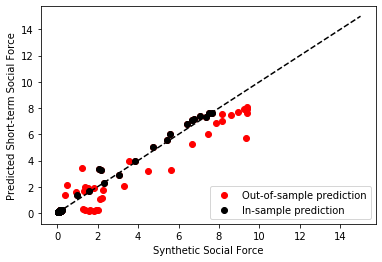

In [93]:
# Plot predicted MPG without error bars
plt.scatter(y_test_list, pred_results,c='red',label='Out-of-sample prediction')

plt.scatter(y_test_list_SEEN, pred_results_SEEN,c='black',label='In-sample prediction')


plt.plot([0, 15], [0, 15], 'k--')
plt.legend(loc='lower right')
plt.xlabel('Synthetic Social Force')
plt.ylabel('Predicted Short-term Social Force')
#plt.savefig('NHPP_aggregated_same.pdf')
plt.savefig('Figures/Short-term-prediction-RF-scatterplot.pdf')
plt.show()